# Building structured multi-plot grids

When exploring multi-dimensional data, a useful approach is to draw multiple instances of the same plot on different subsets of your dataset. This technique is sometimes called either "lattice" or "trellis" plotting, and it is related to the idea of `"small multiples"`. It allows a viewer to quickly extract a large amount of information about a complex dataset. Matplotlib offers good support for making figures with multiple axes; seaborn builds on top of this to directly link the structure of the plot to the structure of your dataset.

The `figure-level` functions are built on top of the objects discussed in this Module. In most cases, you will want to work with those functions. They take care of some important bookkeeping that synchronizes the multiple plots in each grid. This Module explains how the underlying objects work, which may be useful for advanced applications.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks") # Set the theme for the plots
#%matplotlib inline 
import numpy as np
np.random.seed(sum(map(ord, "axis_grids"))) # For reproducibility



## Conditional small multiples
---------------------------

The `FacetGrid` class is useful when you want to visualize the distribution of a variable or the relationship between multiple variables separately within subsets of your dataset. A `FacetGrid` can be drawn with up to three dimensions: ``row``, ``col``, and ``hue``. The first two have obvious correspondence with the resulting array of axes; think of the hue variable as a third dimension along a depth axis, where different levels are plotted with different colors.

Each of `relplot`, `displot`, `catplot`, and `lmplot` use this object internally, and they return the object when they are finished so that it can be used for further tweaking.

The class is used by initializing a `FacetGrid` object with a dataframe and the names of the variables that will form the row, column, or hue dimensions of the grid. These variables should be categorical or discrete, and then the data at each level of the variable will be used for a facet along that axis. For example, say we wanted to examine differences between lunch and dinner in the ``tips`` dataset:

In [2]:
tips = sns.load_dataset("tips")
print(tips.info())
tips.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB
None


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


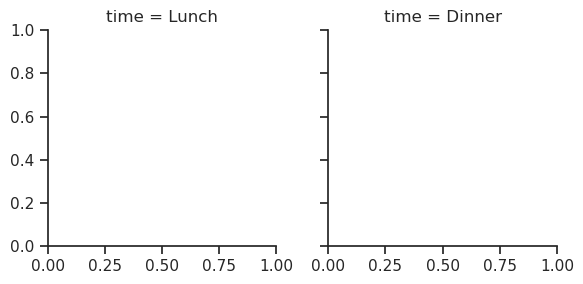

In [3]:
g = sns.FacetGrid(tips, # Create a grid for faceting
                  col="time") # Column-wise faceting by 'time' variable, we have two, Lunch and Dinner
#we create two plots, one for Lunch and one for Dinner, but are not displaying any data yet because we have not mapped any data to the grid

Initializing the grid like this sets up the matplotlib figure and axes, but doesn't draw anything on them.

The main approach for visualizing data on this grid is with the `FacetGrid.map` method. Provide it with a plotting function and the name(s) of variable(s) in the dataframe to plot. Let's look at the distribution of tips in each of these subsets, using a histogram:

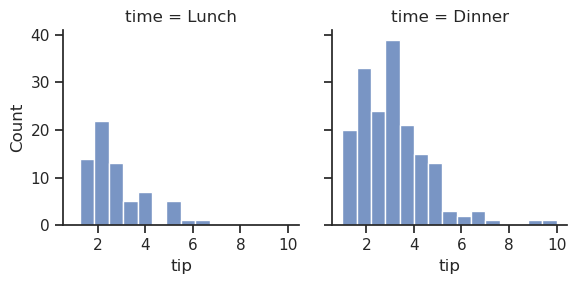

In [ ]:
g = sns.FacetGrid(tips, # Create a grid for faceting, this must be in the same code cell as this is what "prints" the grid
                  col="time") # Column-wise faceting by 'time' variable, we have two, Lunch and Dinner
# we assign a plot type to the grid (g), now we map a histogram to each facet
g.map(sns.histplot, "tip")# Plot histogram of 'tip' variable in each facet



This function will draw the figure and annotate the axes, hopefully producing a finished plot in one step. To make a relational plot, just pass multiple variable names. You can also provide keyword arguments, which will be passed to the plotting function:

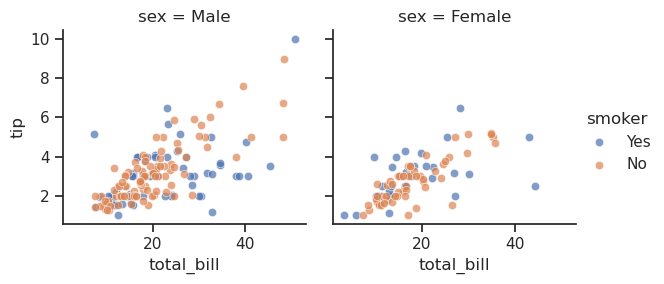

In [8]:
g = sns.FacetGrid(tips, col="sex", hue="smoker") # Create a grid with column-wise faceting by 'sex' and hue by 'smoker' status, use the tips dataset
g.map(sns.scatterplot, "total_bill", "tip", alpha=.7) # Map a scatter plot of 'total_bill' vs 'tip' to the grid with some transparency
g.add_legend() # Add a legend to the grid to explain the hue colors

There are several options for controlling the look of the grid that can be passed to the class constructor.

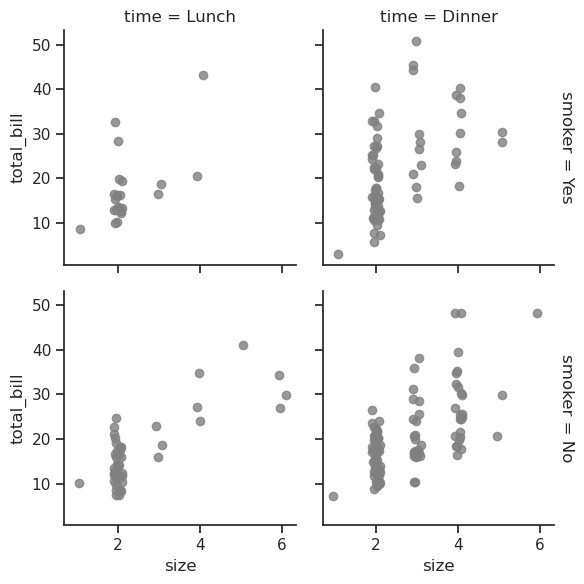

In [ ]:
g = sns.FacetGrid(tips, row="smoker", col="time", # Create a grid with row-wise faceting by 'smoker' status and column-wise by 'time'
                  margin_titles=True) # Add margin titles for better readability
g.map(sns.regplot, "size", "total_bill", # Map a regression plot of 'size' vs 'total_bill' to each facet
      color="grey", # Set the color of the regression line and points
      fit_reg=False, # Do not fit a regression line
      x_jitter=.1) # Add some jitter to the x-axis for better visibility of points
# This creates a grid of scatter plots showing the relationship between 'size' and 'total_bill

Note that ``margin_titles`` isn't formally supported by the matplotlib API, and may not work well in all cases. In particular, it currently can't be used with a legend that lies outside of the plot.

The size of the figure is set by providing the height of *each* facet, along with the aspect ratio:

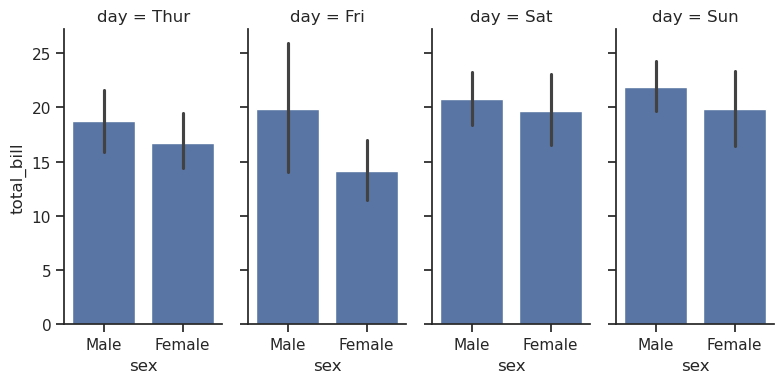

In [14]:
g = sns.FacetGrid(tips, col="day",  # Create a grid with column-wise faceting by 'day'
                  height=4, aspect=.5) # Set the height and aspect ratio of each facet
g.map(sns.barplot, "sex", "total_bill", # Map a bar plot of 'sex' vs 'total_bill' to each facet, each bar represents average total bill for that sex
      #errorbar=None, # remove error bars
      order=["Male", "Female"]) # Specify the order of categories on the x-axis

The default ordering of the facets is derived from the information in the DataFrame. If the variable used to define facets has a categorical type, then the order of the categories is used. Otherwise, the facets will be in the order of appearance of the category levels. It is possible, however, to specify an ordering of any facet dimension with the appropriate ``*_order`` parameter:

In [ ]:
ordered_days = tips.day.value_counts().index # Get the days ordered by frequency
ordered_days

CategoricalIndex(['Sat', 'Sun', 'Thur', 'Fri'], categories=['Thur', 'Fri', 'Sat', 'Sun'], ordered=False, dtype='category', name='day')

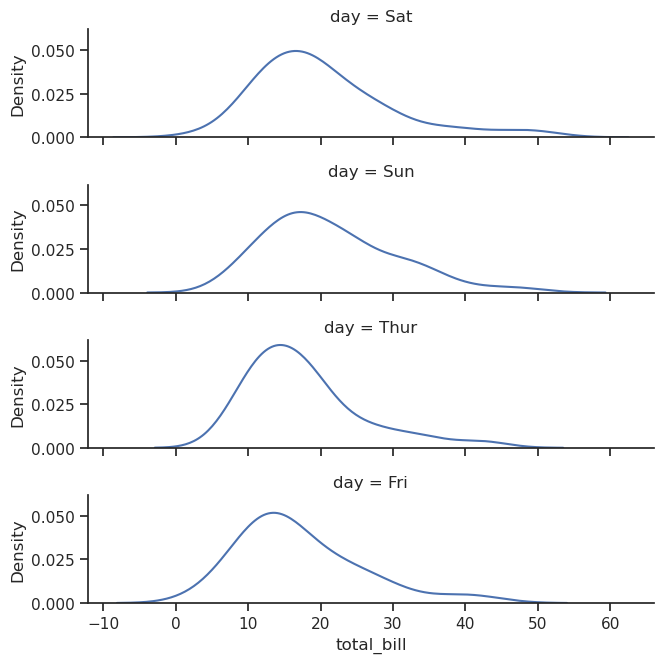

In [ ]:
g = sns.FacetGrid(tips, row="day", # Create a grid with row-wise faceting by 'day' we could change the row to col to have column-wise faceting
                  row_order=ordered_days,# Specify the order of rows based on frequency
                  height=1.7, aspect=4,) # Set the height and aspect ratio of each facet
g.map(sns.kdeplot, "total_bill") # Map a kernel density estimate plot of 'total_bill' to each facet

Any seaborn color palette (i.e., something that can be passed to `color_palette()`) can be provided. You can also use a dictionary that maps the names of values in the ``hue`` variable to valid matplotlib colors:

In [19]:
pal = dict(Lunch="seagreen", Dinner="grey")
pal

{'Lunch': 'seagreen', 'Dinner': 'grey'}

In [20]:
pal_dict = {"Lunch":"seagreen", 
       "Dinner":"grey"}
pal_dict

{'Lunch': 'seagreen', 'Dinner': 'grey'}

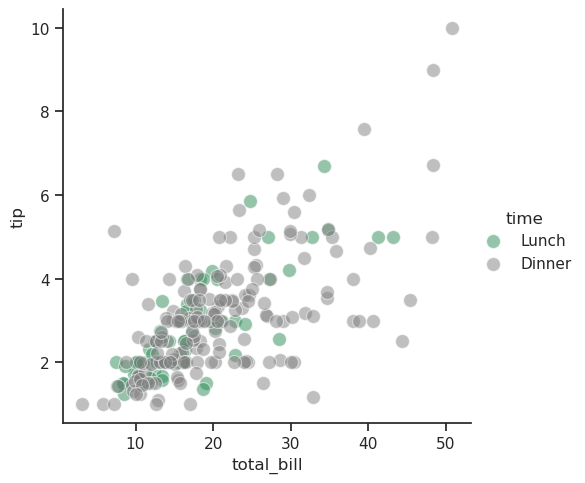

In [ ]:
g = sns.FacetGrid(tips, hue="time", # Create a grid with hue based on 'time' variable, dataset is tips
                  palette=pal, # Use the custom color palette defined earlier from the dictionary
                  height=5) # Set the height of the plot to 5 inches

g.map(sns.scatterplot, "total_bill", "tip", # Map a scatter plot of 'total_bill' vs 'tip' to the grid
      s=100, # Set the size of the scatter plot points
      alpha=.5) # Set the transparency of the points
g.add_legend() # Add a legend to explain the hue colors

If you have many levels of one variable, you can plot it along the columns but "wrap" them so that they span multiple rows. When doing this, you cannot use a ``row`` variable.

In [ ]:
attend = sns.load_dataset("attention").query("subject <= 12") # Load the attention dataset and filter for subjects less than or equal to 12
print(attend.info())
attend.head()


<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 51
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  36 non-null     int64  
 1   subject     36 non-null     int64  
 2   attention   36 non-null     object 
 3   solutions   36 non-null     int64  
 4   score       36 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB
None


,Unnamed: 0,subject,attention,solutions,score
0,0,1,divided,1,2.0
1,1,2,divided,1,3.0
2,2,3,divided,1,3.0
3,3,4,divided,1,5.0
4,4,5,divided,1,4.0


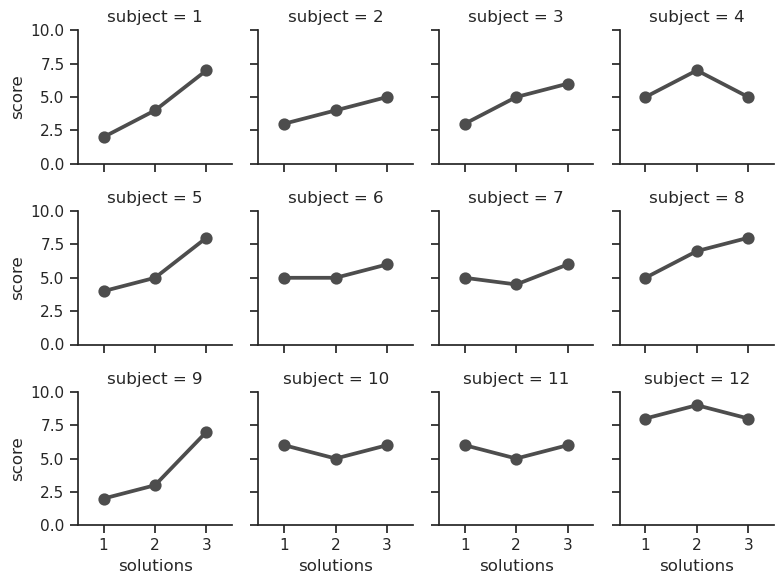

In [ ]:
g = sns.FacetGrid(attend, col="subject", # Create a grid with column-wise faceting by 'subject'
                  col_wrap=4, # Wrap the columns after every 4 facets, this is needed because we have many subjects 
                  height=2, # Set the height of each facet
                  ylim=(0, 10)) # Set the y-axis limits for all facets

g.map(sns.pointplot, "solutions", "score", # Map a point plot of 'solutions' vs 'score' to each facet
      order=[1, 2, 3], # Specify the order of 'solutions' on the x-axis
      color="black", # Set the color of the points and lines
      errorbar=None) # Do not display error bars

Once you've drawn a plot using`FacetGrid.map` (which can be called multiple times), you may want to adjust some aspects of the plot. There are also a number of methods on the `FacetGrid` object for manipulating the figure at a higher level of abstraction. The most general is `FacetGrid.set`, and there are other more specialized methods like `FacetGrid.set_axis_labels`, which respects the fact that interior facets do not have axis labels. For example:

In [ ]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tips, row="sex", col="smoker", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "total_bill", "tip", color="#334488")
g.set_axis_labels("Total bill (US Dollars)", "Tip")
g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
g.figure.subplots_adjust(wspace=.02, hspace=.02)

For even more customization, you can  work directly with the underling matplotlib ``Figure`` and ``Axes`` objects, which are stored as member attributes at ``figure`` and ``axes_dict``, respectively. When making a figure without row or column faceting, you can also use the ``ax`` attribute to directly access the single axes.

In [ ]:
g = sns.FacetGrid(tips, col="smoker", margin_titles=True, height=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
g.set(xlim=(0, 60), ylim=(0, 14))

## Using custom functions
----------------------

You're not limited to existing matplotlib and seaborn functions when using `FacetGrid`. However, to work properly, any function you use must follow a few rules:

1. It must plot onto the "currently active" matplotlib ``Axes``. This will be true of functions in the ``matplotlib.pyplot`` namespace, and you can call `matplotlib.pyplot.gca` to get a reference to the current ``Axes`` if you want to work directly with its methods.
2. It must accept the data that it plots in positional arguments. Internally, `FacetGrid` will pass a ``Series`` of data for each of the named positional arguments passed to `FacetGrid.map`.
3. It must be able to accept ``color`` and ``label`` keyword arguments, and, ideally, it will do something useful with them. In most cases, it's easiest to catch a generic dictionary of ``**kwargs`` and pass it along to the underlying plotting function.

Let's look at minimal example of a function you can plot with. This function will just take a single vector of data for each facet:

In [ ]:
from scipy import stats
def quantile_plot(x, **kwargs):
    quantiles, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, quantiles, **kwargs)
    
g = sns.FacetGrid(tips, col="sex", height=4)
g.map(quantile_plot, "total_bill")

If we want to make a bivariate plot, you should write the function so that it accepts the x-axis variable first and the y-axis variable second:

In [ ]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)
    
g = sns.FacetGrid(tips, col="smoker", height=4)
g.map(qqplot, "total_bill", "tip")

Because `matplotlib.pyplot.scatter` accepts ``color`` and ``label`` keyword arguments and does the right thing with them, we can add a hue facet without any difficulty:

In [ ]:
g = sns.FacetGrid(tips, hue="time", col="sex", height=4)
g.map(qqplot, "total_bill", "tip")
g.add_legend()

Sometimes, though, you'll want to map a function that doesn't work the way you expect with the ``color`` and ``label`` keyword arguments. In this case, you'll want to explicitly catch them and handle them in the logic of your custom function. For example, this approach will allow use to map `matplotlib.pyplot.hexbin`, which otherwise does not play well with the `FacetGrid` API:

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(tips, hue="time", col="time", height=4)
g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10]);

## Plotting pairwise data relationships
------------------------------------

`PairGrid` also allows you to quickly draw a grid of small subplots using the same plot type to visualize data in each. In a `PairGrid`, each row and column is assigned to a different variable, so the resulting plot shows each pairwise relationship in the dataset. This style of plot is sometimes called a "scatterplot matrix", as this is the most common way to show each relationship, but `PairGrid` is not limited to scatterplots.

It's important to understand the differences between a `FacetGrid` and a `PairGrid`. In the former, each facet shows the same relationship conditioned on different levels of other variables. In the latter, each plot shows a different relationship (although the upper and lower triangles will have mirrored plots). Using `PairGrid` can give you a very quick, very high-level summary of interesting relationships in your dataset.

The basic usage of the class is very similar to `FacetGrid`. First you initialize the grid, then you pass plotting function to a ``map`` method and it will be called on each subplot. There is also a companion function, `pairplot` that trades off some flexibility for faster plotting.


In [ ]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g.map(sns.scatterplot)

It's possible to plot a different function on the diagonal to show the univariate distribution of the variable in each column. Note that the axis ticks won't correspond to the count or density axis of this plot, though.

In [ ]:
g = sns.PairGrid(iris)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

A very common way to use this plot colors the observations by a separate categorical variable. For example, the iris dataset has four measurements for each of three different species of iris flowers so you can see how they differ.

In [ ]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

By default every numeric column in the dataset is used, but you can focus on particular relationships if you want.

In [ ]:
g = sns.PairGrid(iris, vars=["sepal_length", "sepal_width"], hue="species")
g.map(sns.scatterplot)

It's also possible to use a different function in the upper and lower triangles to emphasize different aspects of the relationship.

In [ ]:
g = sns.PairGrid(iris)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

The square grid with identity relationships on the diagonal is actually just a special case, and you can plot with different variables in the rows and columns.

In [ ]:
g = sns.PairGrid(tips, y_vars=["tip"], x_vars=["total_bill", "size"], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

Of course, the aesthetic attributes are configurable. For instance, you can use a different palette (say, to show an ordering of the ``hue`` variable) and pass keyword arguments into the plotting functions.

In [ ]:
g = sns.PairGrid(tips, hue="size", palette="GnBu_d")
g.map(plt.scatter, s=50, edgecolor="white")
g.add_legend()

`PairGrid` is flexible, but to take a quick look at a dataset, it can be easier to use `pairplot`. This function uses scatterplots and histograms by default, although a few other kinds will be added (currently, you can also plot regression plots on the off-diagonals and KDEs on the diagonal).

In [ ]:
sns.pairplot(iris, hue="species", height=2.5)

You can also control the aesthetics of the plot with keyword arguments, and it returns the `PairGrid` instance for further tweaking.

In [ ]:
g = sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", height=2.5)

Now we will explore [Statistical Estimation and Error](./Mod8-error_bars.ipynb)